# Secure multiparty computation with neural networks

Below, the secure multiparty computation with 4 parties is implemented with the neural network defined in Plain_NN. The neural network architecture is identical to pytorch, the only difference being that the crypten API is being used.
The neural network architecture and training was build and experimenced with the author based on the tutorials provided by the contributiors and creators of the Crypten library. (B. Knott and S. Venkataraman and A.Y. Hannun and S. Sengupta and M. Ibrahim and L.J.P. van der Maaten, CrypTen: Secure Multi-Party Computation Meets Machine Learning, 2021, arXiv 2109.00984, visited at https://github.com/facebookresearch/CrypTen/tree/main/tutorials on 1 May 2024). 

The neural network was build and experimented by the author, assisted by the Claude, ChatGPT and Gemini Chatbots. (“Please suggest a PyTorch neural network architecture for binary classification”, Claude 3, Anthropic PBC, generated on 27 March 2024., “Please improve this neural network architecture for binary classification…”, ChatGPT (GPT-4), OpenAI, generated on 27 March 2024., “Why is the F2 score of the crypten model worse and how do I improve it”, Gemini, Google (Alphabet Inc.), generated on 30 March 2024.)

Firstly, the necessary libraries are imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import torch
import crypten
from crypten import mpc
import crypten.communicator as comm


from collections import defaultdict
import os
from time import time
import psutil
from tqdm.notebook import tqdm

# This line is to hide the GPU, as simulation of multiple processes performing SMPC only works on the CPU.
os.environ["CUDA_VISIBLE_DEVICES"]=""

# Data cleaning and preparation

As with the plain text model, data is prepared for the usage in the crypten SMPC model.

In [2]:
df_nn = pd.read_csv("card_transdata.csv")

train_transactions, test_transactions = train_test_split(df_nn, test_size=0.2, random_state=42)

X_train_transactions = train_transactions.drop(columns=["fraud"])
y_train_transactions = torch.from_numpy(train_transactions.fraud.values).flatten(0)
X_test_transactions = test_transactions.drop(columns=["fraud"])
y_test_transactions = torch.from_numpy(test_transactions.fraud.values).flatten(0)

scaler = StandardScaler()
X_train_transactions = torch.from_numpy(pd.DataFrame(scaler.fit_transform(X_train_transactions), columns=X_train_transactions.columns, index=X_train_transactions.index).values)
X_test_transactions = torch.from_numpy(pd.DataFrame(scaler.transform(X_test_transactions), columns=X_test_transactions.columns, index=X_test_transactions.index).values)

print(f"X_train_transactions has shape: {X_train_transactions.shape}")
print(f"y_train_transactions has shape: {y_train_transactions.shape}")
print(f"X_test_transactions has shape: {X_test_transactions.shape}")
print(f"y_test_transactions has shape: {y_test_transactions.shape}")

X_train_transactions has shape: torch.Size([800000, 7])
y_train_transactions has shape: torch.Size([800000])
X_test_transactions has shape: torch.Size([200000, 7])
y_test_transactions has shape: torch.Size([200000])


## Crypten neural network architecture

Below the crypten neural network architecture is defined, which is identical to the pytorch plaintext architecture.

In [3]:
class CryptenFraudDetectionModel(crypten.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CryptenFraudDetectionModel, self).__init__()
        self.fc1 = crypten.nn.Linear(input_size, hidden_size)
        self.relu = crypten.nn.ReLU()
        self.dropout = crypten.nn.Dropout(0.5)
        self.bn1 = crypten.nn.BatchNorm1d(hidden_size)
        self.fc2 = crypten.nn.Linear(hidden_size, hidden_size)
        self.relu = crypten.nn.ReLU()
        self.bn1 = crypten.nn.BatchNorm1d(hidden_size)
        self.fc3 = crypten.nn.Linear(hidden_size, num_classes)
        self.bn2 = crypten.nn.BatchNorm1d(num_classes)
        self.sigmoid = crypten.nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.fc3(x)
        x = self.bn2(x)
        x = self.sigmoid(x)
        return x

input_size = 7
hidden_size = 64
num_classes = 1
model = CryptenFraudDetectionModel(input_size, hidden_size, num_classes)

## Crypten initialization

Below, the crypten and torch libraries are initialised.

In [4]:
crypten.init()
torch.set_num_threads(1)

## Splitting of the data and encryption into multiparty computation tensors

The code below splits the data set into 4 parts, simulating 4 parties. The dataset are encrypted into secret shares, using arithmetic and binary secret sharing. The datasets are then stored as .pth files.

The commented code can be used to simulate 4 separate processes training the neural network model. 

In [5]:
bank1 = 0
bank2 = 1
bank3 = 2
bank4 = 3

# Specify file locations to save data for each bank
filenames = {
    "X_samples_bank1": "data/X_samples_bank1.pth",
    "X_samples_bank2": "data/X_samples_bank2.pth",
    "X_samples_bank3": "data/X_samples_bank3.pth",
    "X_samples_bank4": "data/X_samples_bank4.pth",
    "y_samples_bank1": "data/y_samples_bank1.pth",
    "y_samples_bank2": "data/y_samples_bank2.pth",
    "y_samples_bank3": "data/y_samples_bank3.pth",
    "y_samples_bank4": "data/y_samples_bank4.pth",
}

@mpc.run_multiprocess(world_size=4)
def save_all_data():   
    # Save split dataset for the 4 banks
    X_samples_bank1 = X_train_transactions[:5000]
    X_samples_bank2 = X_train_transactions[5000:10000]
    X_samples_bank3 = X_train_transactions[10000:15000]
    X_samples_bank4 = X_train_transactions[15000:20000]
    crypten.save_from_party(X_samples_bank1, filenames["X_samples_bank1"],src = bank1)
    crypten.save_from_party(X_samples_bank2, filenames["X_samples_bank2"],src = bank2)
    crypten.save_from_party(X_samples_bank3, filenames["X_samples_bank3"],src = bank3)
    crypten.save_from_party(X_samples_bank4, filenames["X_samples_bank4"],src = bank4)

    # crypten.save_from_party(X_samples_bank1, filenames["X_samples_bank1"])
    # crypten.save_from_party(X_samples_bank2, filenames["X_samples_bank2"])
    # crypten.save_from_party(X_samples_bank3, filenames["X_samples_bank3"])
    # crypten.save_from_party(X_samples_bank4, filenames["X_samples_bank4"])

    y_samples_bank1 = y_train_transactions[:5000]
    y_samples_bank2 = y_train_transactions[5000:10000]
    y_samples_bank3 = y_train_transactions[10000:15000]
    y_samples_bank4 = y_train_transactions[15000:20000]
    crypten.save_from_party(y_samples_bank1, filenames["y_samples_bank1"],src = bank1)
    crypten.save_from_party(y_samples_bank2, filenames["y_samples_bank2"],src = bank2)
    crypten.save_from_party(y_samples_bank3, filenames["y_samples_bank3"],src = bank3)
    crypten.save_from_party(y_samples_bank4, filenames["y_samples_bank4"],src = bank4)

    # crypten.save_from_party(y_samples_bank1, filenames["y_samples_bank1"])
    # crypten.save_from_party(y_samples_bank2, filenames["y_samples_bank2"])
    # crypten.save_from_party(y_samples_bank3, filenames["y_samples_bank3"])
    # crypten.save_from_party(y_samples_bank4, filenames["y_samples_bank4"])
    
    
save_all_data()


[None, None, None, None]

## Training of the neural network model

The function below loads the data and train the crypten neural network model. The model can be trained with the GPU, when the model is trained in one process without isolation.

However, a multiparty computation can be simulated by using the @mpc.run_multiprocess(world_size=4), which simulates 4 isolated processes training the model. A crypten model can only be trained when its parameters are also encrypted. For the training of the model without encrypting the parameters or decrypting it with each iteration or epoch, a manual implementation is needed. For the evaluation CPU is used, as simulation with 4 parties does not support the GPU.

In [6]:
@mpc.run_multiprocess(world_size=4)
def encrypted_training():
    # Load data:
    x_bank1_enc = crypten.load_from_party(filenames['X_samples_bank1'], src=bank1)
    x_bank2_enc = crypten.load_from_party(filenames['X_samples_bank2'], src=bank2)
    x_bank3_enc = crypten.load_from_party(filenames['X_samples_bank3'], src=bank3)
    x_bank4_enc = crypten.load_from_party(filenames['X_samples_bank4'], src=bank4)

    y_bank1_enc = crypten.load_from_party(filenames['y_samples_bank1'], src=bank1)
    y_bank2_enc = crypten.load_from_party(filenames['y_samples_bank2'], src=bank2)
    y_bank3_enc = crypten.load_from_party(filenames['y_samples_bank3'], src=bank3)
    y_bank4_enc = crypten.load_from_party(filenames['y_samples_bank4'], src=bank4)

    # x_bank1_enc = crypten.load_from_party(filenames['X_samples_bank1'])
    # x_bank2_enc = crypten.load_from_party(filenames['X_samples_bank2'])
    # x_bank3_enc = crypten.load_from_party(filenames['X_samples_bank3'])
    # x_bank4_enc = crypten.load_from_party(filenames['X_samples_bank4'])

    # y_bank1_enc = crypten.load_from_party(filenames['y_samples_bank1'])
    # y_bank2_enc = crypten.load_from_party(filenames['y_samples_bank2'])
    # y_bank3_enc = crypten.load_from_party(filenames['y_samples_bank3'])
    # y_bank4_enc = crypten.load_from_party(filenames['y_samples_bank4'])
    model.encrypt()
    # Set train mode
    model.train()

    # Combine the feature sets: identical to Tutorial 3
    x_combined_enc = crypten.cat([x_bank1_enc, x_bank2_enc, x_bank3_enc, x_bank4_enc], dim=0)
    y_combined_enc= crypten.cat([y_bank1_enc, y_bank2_enc, y_bank3_enc, y_bank4_enc], dim=0)
    # print(y_combined)
    crypten.print(x_combined_enc.size())
    crypten.print(y_combined_enc.size())

    loss = crypten.nn.loss.BCELoss()
    rank = comm.get().get_rank()

    # Define training parameters
    learning_rate = 0.005
    num_epochs = 10
    batch_size = 32
    num_batches = x_combined_enc.size(0) // batch_size
    
    for i in tqdm(range(num_epochs)):   
    
        for batch in range(num_batches):
            # define the start and end of the training mini-batch
            start, end = batch * batch_size, (batch + 1) * batch_size
                                    
            # construct CrypTensors out of training examples / labels
            x_train = x_combined_enc[start:end]
            x_train.requires_grad = True

            y_train = y_combined_enc[start:end]
            y_train.requires_grad = True

            # perform forward pass:
            output = model(x_train)
            loss_value = loss(output, y_train.unsqueeze(1))
            
            # set gradients to "zero" 
            model.zero_grad()

            # perform backward pass: 
            loss_value.backward()

            # update parameters
            model.update_parameters(learning_rate)
            
            # Print progress every batch:
            
        batch_loss = loss_value.get_plain_text()
        accuracy = accuracy_score(np.where(output.get_plain_text() > 0.5, 1, 0), y_train.get_plain_text())
        f2_score = fbeta_score(np.where(output.get_plain_text() > 0.5, 1, 0), y_train.get_plain_text(), beta=0.5)
        crypten.print(f"Loss at epoch {i} {batch_loss.item():.4f}")
        crypten.print(f"Accuracy at epoch {i} {accuracy:.4f}")
        crypten.print(f"F2 score at epoch {i} {f2_score:.4f}")




Below, the training if the encrypted model is performed.

In [7]:
# measure time
t_start = time()
# measure resource usage
mem_usage = psutil.Process().memory_info().rss
encrypted_training()
mem_usage_end = psutil.Process().memory_info().rss

# Calculate the differences
mem_diff = mem_usage_end - mem_usage
t_end = time()
print(f"Training of the neural network took {int(t_end - t_start)} seconds")
print(f"Memory usage difference: {mem_diff} bytes")

torch.Size([20000, 7])
torch.Size([20000])


  0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 0 0.3553
Accuracy at epoch 0 0.9688
F2 score at epoch 0 0.7143
Loss at epoch 1 0.2997
Accuracy at epoch 1 0.9375
F2 score at epoch 1 0.3846
Loss at epoch 2 0.2630
Accuracy at epoch 2 0.9062
F2 score at epoch 2 0.6250
Loss at epoch 3 0.2189
Accuracy at epoch 3 0.9375
F2 score at epoch 3 0.3846
Loss at epoch 4 0.2125
Accuracy at epoch 4 0.9375
F2 score at epoch 4 0.3846
Loss at epoch 5 0.1787
Accuracy at epoch 5 0.9375
F2 score at epoch 5 0.3846
Loss at epoch 6 0.2301
Accuracy at epoch 6 0.9375
F2 score at epoch 6 0.3846
Loss at epoch 7 0.1754
Accuracy at epoch 7 0.9688
F2 score at epoch 7 0.7143
Loss at epoch 8 0.1664
Accuracy at epoch 8 0.9688
F2 score at epoch 8 0.7143
Loss at epoch 9 0.1788
Accuracy at epoch 9 0.9375
F2 score at epoch 9 0.3846
Training of the neural network took 8624 seconds
Memory usage difference: 196608 bytes


Finally, the crypten model is evaluated on the test set.

In [19]:
model.eval()
output_test = model(crypten.cryptensor(X_test_transactions))
output_test = output_test.get_plain_text()


accuracy = accuracy_score(np.where(output_test > 0.5, 1, 0), y_test_transactions)
f2_test = fbeta_score(np.where(output_test > 0.5, 1, 0), y_test_transactions, beta=0.5)
print("Accuracy score: {}".format(accuracy))
print("F2 score: {}".format(f2_test))


Accuracy score: 0.09171
F2 score: 0.3241944422747172


Below, helper functions for the visualisation of the performance on the training set are defined.

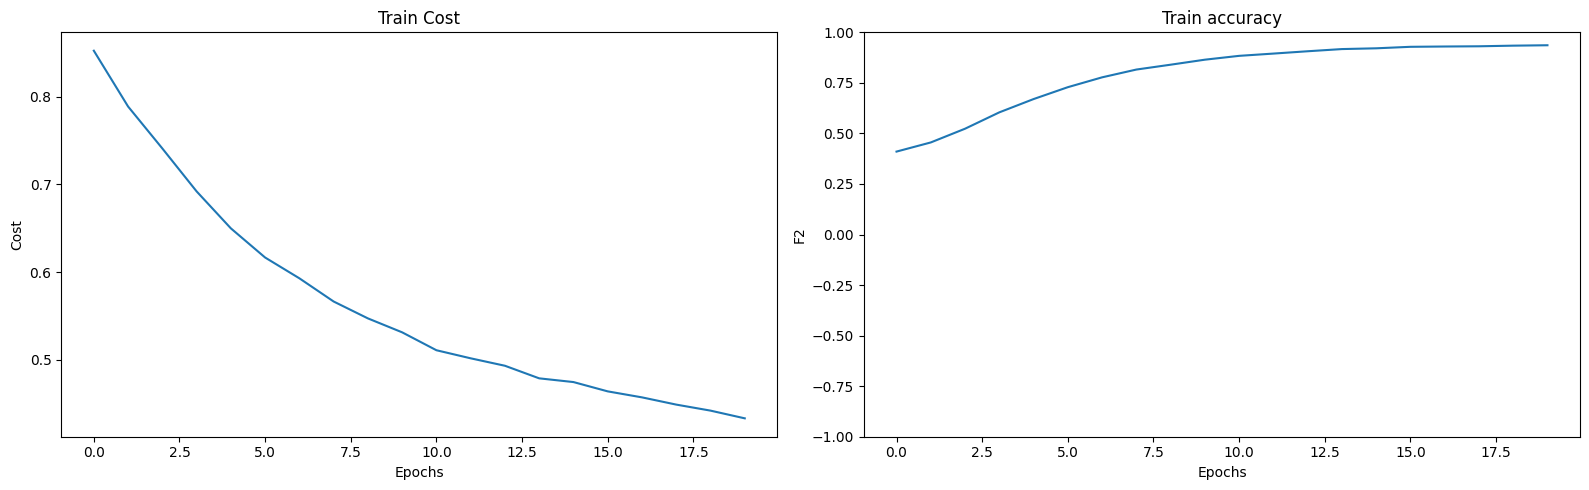

In [ ]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves_acc(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train accuracy")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_accuracy"], ax[1])

    plt.tight_layout()

plot_validation_curves_acc(hist)

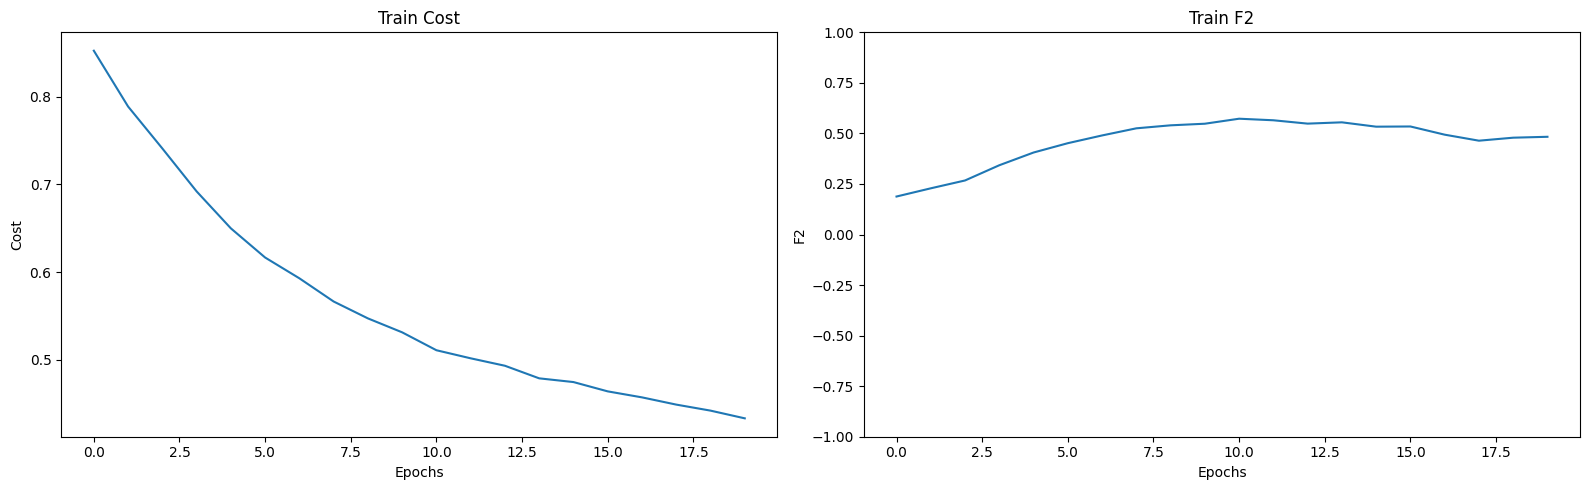

In [ ]:
def plot_validation_curves_f2(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train F2")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_f2"], ax[1])

    plt.tight_layout()

plot_validation_curves_f2(hist)